### Fused Network
- Edge filtering: On edge weight, time window, and sentiment.
- Node Pruning: on eigenvector centrality.

In [1]:
import torch
import pandas as pd
import time
import ast
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import pickle
import networkx as nx


In [3]:
en_text = nx.read_gexf("en_text_graph_new.gexf") 
en_domain = nx.read_gexf("en_co_domain_network.gexf") 
en_tag = nx.read_gexf("en_co_hashtag_graph_new.gexf") 


In [4]:
es_text = nx.read_gexf("es_text_graph.gexf") 
es_domain = nx.read_gexf("es_co_domain_network.gexf") 
es_tag = nx.read_gexf("es_co_hashtag_graph_new.gexf") 


In [5]:
en_data = pd.read_csv('en_sent.csv')
es_data = pd.read_csv('es_sent.csv')


In [6]:
def convert_format(field):
    return ast.literal_eval(field)

en_data['hashtags'] = en_data['hashtags'].apply(convert_format)
en_data['links'] = en_data['links'].apply(convert_format)
en_data['mentionedUsers'] = en_data['mentionedUsers'].apply(convert_format)

es_data['hashtags'] = es_data['hashtags'].apply(convert_format)
es_data['links'] = es_data['links'].apply(convert_format)
es_data['mentionedUsers'] = es_data['mentionedUsers'].apply(convert_format)


#### Measure the sentiment of each tweet for future usage

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the sentiment model
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student").to(device)


In [7]:
# def get_sentiment(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
#     outputs = model(**inputs)
#     sentiment = torch.argmax(outputs.logits, dim=1).item()  # 0: negative, 1: neutral, 2: positive
#     return sentiment


In [ ]:
def precompute_sentiments(dataframe):
    """
    Adds a 'sentiment' column to the DataFrame with precomputed sentiment values in batch.

    Parameters:
    - dataframe: DataFrame containing tweet text in the 'text' column.

    Returns:
    - dataframe: Updated DataFrame with a new 'sentiment' column.
    """
    # Prepare texts for sentiment analysis
    texts = dataframe['text'].fillna("").tolist()

    # Tokenize and process in batches
    sentiments = []
    batch_size = 128
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
        outputs = model(**inputs)
        batch_sentiments = torch.argmax(outputs.logits, dim=1).cpu().tolist()
        sentiments.extend(batch_sentiments)

    dataframe['sentiment'] = sentiments
    return dataframe


# Precompute sentiments for en_data
en_data = precompute_sentiments(en_data)
es_data = precompute_sentiments(es_data)


In [12]:
# en_data.to_csv("en_sent.csv",index=False)
# es_data.to_csv("es_sent.csv",index=False)


### 1. English

In [45]:
# Align node sets across networks (if node sets differ)
en_all_nodes = set(en_text.nodes()) | set(en_domain.nodes()) | set(en_tag.nodes())
for graph in [en_text, en_domain, en_tag]:
    for node in en_all_nodes:
        if node not in graph:
            graph.add_node(node)


In [46]:
def construct_fused_network(graphs):
    fused_graph = nx.Graph()
    for graph in graphs:
        for u, v, data in graph.edges(data=True):
            if fused_graph.has_edge(u, v):
                fused_graph[u][v]['weight'] += data.get('weight', 1)
            else:
                fused_graph.add_edge(u, v, weight=data.get('weight', 1))
    return fused_graph


In [47]:
# Construct fused network from individual networks
en_fused_graph = construct_fused_network([en_text, en_domain, en_tag])

In [9]:
def filter_edges_by_sentiment_and_time(dataframe, graph, time_window=3600):
    filtered_graph = nx.Graph()
    
    sentiment_map = dataframe.set_index('text')['sentiment'].to_dict()
    
    for u, v, data in graph.edges(data=True):
        u_tweets = dataframe[dataframe['id_str'] == u]
        v_tweets = dataframe[dataframe['id_str'] == v]
        
        for _, u_row in u_tweets.iterrows():
            for _, v_row in v_tweets.iterrows():
                if abs(u_row['epoch'] - v_row['epoch']) <= time_window:
                    u_sentiment = sentiment_map.get(u_row['text'])
                    v_sentiment = sentiment_map.get(v_row['text'])
                    
                    if u_sentiment == v_sentiment:
                        filtered_graph.add_edge(u, v, weight=data.get('weight', 1))
                        break 
            else:
                continue 
            break 
    return filtered_graph


In [10]:
def filter_edges_by_time(dataframe, graph, time_window=3600):
    filtered_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        u_tweets = dataframe[dataframe['id_str'] == u]
        v_tweets = dataframe[dataframe['id_str'] == v]

        for _, u_row in u_tweets.iterrows():
            for _, v_row in v_tweets.iterrows():
                if abs(u_row['epoch'] - v_row['epoch']) <= time_window:
                    filtered_graph.add_edge(u, v, weight=data.get('weight', 1))
                    break
    return filtered_graph


In [52]:
def filter_edges_by_percentile(graph, percentile=50):
    """
    Filters out the lowest percentile of edges by weight in the graph.

    Parameters:
    - graph: NetworkX graph to filter.
    - percentile: Percentile threshold for edge weight filtering.

    Returns:
    - filtered_graph: A new graph with edges above the specified percentile retained.
    """
    # Extract edge weights
    edge_weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    
    # Calculate the weight threshold for the given percentile
    weight_threshold = np.percentile(edge_weights, percentile)
    
    # Create a new graph with filtered edges
    filtered_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        if data['weight'] > weight_threshold:
            filtered_graph.add_edge(u, v, weight=data['weight'])
    
    return filtered_graph

In [43]:
# Apply sentiment and time filtering
en_filtered_graph = filter_edges_by_sentiment_and_time(en_data, en_fused_graph, time_window=3600)


In [16]:
en_filtered_graph_time_only = filter_edges_by_time(en_data, en_fused_graph, time_window=3600)


In [11]:
def prune_nodes_by_centrality(graph, centrality_threshold=1e-2):
    eigen_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    nodes_to_keep = [node for node, centrality in eigen_centrality.items() if centrality >= centrality_threshold]
    pruned_graph = graph.subgraph(nodes_to_keep).copy()
    return pruned_graph, eigen_centrality



In [ ]:
# Prune nodes based on eigenvector centrality
centrality_threshold = 1e-2
en_pruned_graph, en_eigen_centrality = prune_nodes_by_centrality(en_filtered_graph, centrality_threshold)


In [12]:
# Print final graph statistics
print(f"Final graph - Nodes: {en_pruned_graph.number_of_nodes()}, Edges: {en_pruned_graph.number_of_edges()}")

# Identify top nodes by eigenvector centrality
top_centrality = sorted(en_eigen_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by eigenvector centrality:")
for node, centrality in top_centrality:
    print(f"Node: {node}, Centrality: {centrality}")


Final graph - Nodes: 160, Edges: 1354
Top 10 nodes by eigenvector centrality:
Node: '1323861935385800705', Centrality: 0.2143737489673948
Node: '390127278', Centrality: 0.21418328585022808
Node: '1748465622965481472', Centrality: 0.1974944800674837
Node: '1607179494267453440', Centrality: 0.19659510720756682
Node: '4249328180', Centrality: 0.19409758980626754
Node: '1759036487549480960', Centrality: 0.1846723776880097
Node: '1518684152211537920', Centrality: 0.18145270024664986
Node: '1518778017669033984', Centrality: 0.17843966691012528
Node: '1463720040717602816', Centrality: 0.17490870463800323
Node: '1574732175647412224', Centrality: 0.17431614018076474


In [13]:
# en_pruned_graph
nx.write_gexf(en_pruned_graph, "en_pruned_graph.gexf")

#### Baseline (Node pruning only, without edge filtering)

In [14]:
en_pruned_baseline, en_eigen_centrality_baseline = prune_nodes_by_centrality(en_fused_graph, centrality_threshold)


In [15]:
# Print final graph statistics
print(f"Final graph - Nodes: {en_pruned_baseline.number_of_nodes()}, Edges: {en_pruned_baseline.number_of_edges()}")

# Identify top nodes by eigenvector centrality
top_centrality = sorted(en_eigen_centrality_baseline.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by eigenvector centrality:")
for node, centrality in top_centrality:
    print(f"Node: {node}, Centrality: {centrality}")


Final graph - Nodes: 216, Edges: 2114
Top 10 nodes by eigenvector centrality:
Node: '1607179494267453440', Centrality: 0.19864401750239835
Node: '390127278', Centrality: 0.19795062705419925
Node: '1323861935385800705', Centrality: 0.19785908615797626
Node: '1748465622965481472', Centrality: 0.19679186906440013
Node: '4249328180', Centrality: 0.18313791079290775
Node: '1518684152211537920', Centrality: 0.18227892228721312
Node: '1518778017669033984', Centrality: 0.1804338689400121
Node: '1523440939594928128', Centrality: 0.17945337485992147
Node: '1759036487549480960', Centrality: 0.17914986498330182
Node: '1574732175647412224', Centrality: 0.17776157569993575


In [16]:
nx.write_gexf(en_pruned_baseline, "en_pruned_baseline.gexf")

#### Lower the time window

In [17]:
en_filtered_time_lower = filter_edges_by_sentiment_and_time(en_data, en_fused_graph, time_window=600)
en_pruned_graph_time_lower, en_eigen_centrality_time_lower = prune_nodes_by_centrality(en_filtered_time_lower, centrality_threshold)


In [19]:
nx.write_gexf(en_pruned_graph_time_lower, "en_pruned_graph_time_lower.gexf")

In [18]:
# Print final graph statistics
print(f"Final graph - Nodes: {en_filtered_time_lower.number_of_nodes()}, Edges: {en_filtered_time_lower.number_of_edges()}")

# Identify top nodes by eigenvector centrality
top_centrality = sorted(en_eigen_centrality_time_lower.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by eigenvector centrality:")
for node, centrality in top_centrality:
    print(f"Node: {node}, Centrality: {centrality}")


Final graph - Nodes: 569, Edges: 1451
Top 10 nodes by eigenvector centrality:
Node: '390127278', Centrality: 0.3136516049005446
Node: '1323861935385800705', Centrality: 0.30805036676340986
Node: '1607179494267453440', Centrality: 0.21613576859689723
Node: '4861982862', Centrality: 0.2104407320584874
Node: '1518684152211537920', Centrality: 0.19838995990362873
Node: '1463720040717602816', Centrality: 0.19406672668134312
Node: '4249328180', Centrality: 0.19386027035134404
Node: '1096037705790750721', Centrality: 0.16189420312652011
Node: '234840640', Centrality: 0.15821915322288715
Node: '22281138', Centrality: 0.1530995235999191


#### Time only

In [20]:
en_pruned_graph_time_only, en_eigen_centrality_time_only = prune_nodes_by_centrality(en_filtered_graph_time_only)


In [22]:
nx.write_gexf(en_pruned_graph_time_only, "en_pruned_graph_time_only.gexf")

### Cluster analysis

In [12]:
en_fused_no_filtering = pd.read_csv('en_fused_network.csv')


In [13]:
en_fused_no_filtering

,Id,Label,modularity_class,componentnumber,eigencentrality,Size
0,'1759036487549480960','1759036487549480960',2,0,0.896465,10
1,'142096963','142096963',0,0,0.115737,10
2,'1663260936994471937','1663260936994471937',0,0,0.115263,10
3,'21651982','21651982',0,0,0.164033,10
4,'454432735','454432735',0,0,0.135149,10
...,...,...,...,...,...,...
211,'1437932372876476422','1437932372876476422',1,0,0.100063,10
212,'1601948775681085440','1601948775681085440',3,0,0.022743,10
213,'2884771','2884771',0,0,0.077815,10
214,'1594158299552878594','1594158299552878594',1,0,0.068495,10


In [15]:
en_all = pd.read_csv('en_fused_all.csv')
en_all

,Id,Label,modularity_class,eigencentrality,Size
0,'1759036487549480960','1759036487549480960',3,0.862916,17.994017
1,'827361801192890368','827361801192890368',3,0.161168,7.725148
2,'1798678161137270784','1798678161137270784',1,0.120703,7.133018
3,'1587871546978320384','1587871546978320384',3,0.319088,10.036034
4,'722832446798999552','722832446798999552',2,0.091928,6.711946
...,...,...,...,...,...
155,'1769847288317251584','1769847288317251584',1,0.049269,6.087699
156,'1437932372876476422','1437932372876476422',2,0.105509,6.910685
157,'1594158299552878594','1594158299552878594',1,0.071296,6.410036
158,'1404423686459961345','1404423686459961345',3,0.173999,7.912906


In [33]:
en_all.sort_values(by='eigencentrality',ascending=False).head(10)

,Id,Label,modularity_class,eigencentrality,Size
44,'390127278','390127278',1,1.000000,20.000000
49,'1323861935385800705','1323861935385800705',1,0.998083,19.971941
98,'1748465622965481472','1748465622965481472',3,0.924451,18.894470
8,'1607179494267453440','1607179494267453440',1,0.919964,18.828817
118,'4249328180','4249328180',3,0.906999,18.639091
0,'1759036487549480960','1759036487549480960',3,0.862916,17.994017
132,'1518684152211537920','1518684152211537920',2,0.843880,17.715450
89,'1518778017669033984','1518778017669033984',2,0.835776,17.596865
95,'1463720040717602816','1463720040717602816',2,0.818683,17.346737
5,'1574732175647412224','1574732175647412224',3,0.815715,17.303310


In [19]:
from collections import Counter

def get_top_domains(df, data):
    """
    Prints the 10 most common tags in a cluster of nodes.

    Parameters:
    - df: DataFrame representing the cluster, containing user IDs in the 'Id' column.
    - data: DataFrame containing the raw tweet data for the respective language.
    """
    tags = []

    # Iterate over each user in the cluster
    for i, r in df.iterrows():
        user = r['Id'] 
        user_data = data[data['id_str'] == user] 
        
        for _, row in user_data.iterrows():
            hashtags = row['hashtags']
            if isinstance(hashtags, list):
                for tag in hashtags:
                    if 'text' in tag:
                        tags.append(tag['text'].lower())

    print(Counter(tags).most_common(10))
    print(f"Cluster size: {df.shape[0]}")
    print(f"Avg EC: {df['eigencentrality'].mean()}")
    print(f"Max EC: {df.sort_values(by='eigencentrality', ascending=False).head(2)}")


In [ ]:
from bertopic import BERTopic
from collections import Counter
from bertopic.representation import KeyBERTInspired


def get_top_topics(cluster_df, data_df):
    """
    Analyzes the top topics in a cluster using BERTopic.

    Parameters:
    - cluster_df: DataFrame representing the cluster, containing user IDs in the 'Id' column and 'eigencentrality'.
    - data_df: DataFrame containing the raw tweet data, with user IDs in 'id_str' and tweets in 'text'.
    """
    # Extract tweets for users in the cluster
    texts = []
    for _, row in cluster_df.iterrows():
        user = row['Id']
        user_data = data_df[data_df['id_str'] == user]
        
        for _, tweet_row in user_data.iterrows():
            tweet = tweet_row['text']
            if isinstance(tweet, str) and len(tweet) > 0:
                texts.append(tweet)

    # Check if texts are non-empty
    if not texts:
        print("No texts available in this cluster.")
        return

    # Apply BERTopic
    representation_model = KeyBERTInspired()
    topic_model = BERTopic(language="multilingual", representation_model=representation_model)
    topics, probs = topic_model.fit_transform(texts)

    # Get the most common topics
    print(topic_model.get_topic(10))
    
    # Cluster metrics
    print(f"\nCluster size: {cluster_df.shape[0]}")
    print(f"Avg Eigenvector Centrality (EC): {cluster_df['eigencentrality'].mean()}")
    print("Top 2 Nodes by EC:")
    print(cluster_df.nlargest(2, 'eigencentrality')[['Id', 'eigencentrality']])


#### Edge filtered:

In [23]:
get_top_domains(en_all[en_all['modularity_class']==2], en_data)

[('demsunited', 13), ('demvoice1', 13), ('resistanceunited', 13), ('proudblue', 11), ('project2025', 10), ('maga', 8), ('trump2024', 7), ('trump', 7), ('kamalaharris', 3), ('godblessamerica', 2)]
Cluster size: 53
Avg EC: 0.22796207547169806
Max EC:                         Id                  Label  modularity_class  \
132  '1518684152211537920'  '1518684152211537920'                 2   
89   '1518778017669033984'  '1518778017669033984'                 2   

     eigencentrality       Size  
132         0.843880  17.715450  
89          0.835776  17.596865  


In [24]:
get_top_domains(en_all[en_all['modularity_class']==3], en_data)

[('trump2024', 7), ('maga', 5), ('kamalaharris', 4), ('copycatkamala', 3), ('trump2024tosaveamerica', 2), ('scotus', 2), ('timwalz', 2), ('votetrumptosaveamerica', 2), ('specialreport', 1), ('kingcharles', 1)]
Cluster size: 53
Avg EC: 0.32825520754716975
Max EC:                         Id                  Label  modularity_class  \
98   '1748465622965481472'  '1748465622965481472'                 3   
118           '4249328180'           '4249328180'                 3   

     eigencentrality       Size  
98          0.924451  18.894470  
118         0.906999  18.639091  


In [25]:
get_top_domains(en_all[en_all['modularity_class']==1], en_data)

[('maga', 17), ('bidenworstpresidentever', 9), ('trump2024tosaveamerica', 6), ('trump2024', 5), ('trump', 3), ('project2025', 3), ('trumpassasinationattempt', 3), ('bidensamerica', 3), ('godblessamerica', 3), ('dilleymemeteam', 3)]
Cluster size: 44
Avg EC: 0.2726176136363637
Max EC:                        Id                  Label  modularity_class  \
44            '390127278'            '390127278'                 1   
49  '1323861935385800705'  '1323861935385800705'                 1   

    eigencentrality       Size  
44         1.000000  20.000000  
49         0.998083  19.971941  


In [26]:
get_top_domains(en_all[en_all['modularity_class']==0], en_data)

[('webackbidenharris', 2), ('falseflag', 2), ('harriswalz2024', 1), ('wearenotgoingback', 1), ('triggered', 1), ('trump2024maga', 1)]
Cluster size: 10
Avg EC: 0.2539861
Max EC:                        Id                  Label  modularity_class  \
12             '22281138'             '22281138'                 0   
72  '1439286507722924036'  '1439286507722924036'                 0   

    eigencentrality       Size  
12         0.798055  17.044889  
72         0.315359   9.981466  


#### No edge filtered

In [27]:
get_top_domains(en_fused_no_filtering[en_fused_no_filtering['modularity_class']==2], en_data)

[('maga', 14), ('bidenworstpresidentever', 9), ('trump2024tosaveamerica', 8), ('trump2024', 6), ('trumpassasinationattempt', 4), ('kamalaharris', 4), ('trumpvance2024', 3), ('bidensamerica', 3), ('godblessamerica', 3), ('copycatkamala', 3)]
Cluster size: 83
Avg EC: 0.346487421686747
Max EC:                         Id                  Label  modularity_class  \
61             '390127278'            '390127278'                 2   
136  '1748465622965481472'  '1748465622965481472'                 2   

     componentnumber  eigencentrality  Size  
61                 0         0.992112    10  
136                0         0.990904    10  


In [28]:
get_top_domains(en_fused_no_filtering[en_fused_no_filtering['modularity_class']==3], en_data)

[('foxnews', 7), ('kamala', 1), ('bidenharris', 1), ('impression', 1), ('comedy', 1)]
Cluster size: 11
Avg EC: 0.026395454545454545
Max EC:                Id         Label  modularity_class  componentnumber  \
158  '4899465914'  '4899465914'                 3                0   
98     '24841259'    '24841259'                 3                0   

     eigencentrality  Size  
158         0.044063    10  
98          0.041991    10  


In [29]:
get_top_domains(en_fused_no_filtering[en_fused_no_filtering['modularity_class']==1], en_data)

[('maga', 16), ('project2025', 15), ('demsunited', 13), ('demvoice1', 13), ('resistanceunited', 13), ('trump2024', 11), ('proudblue', 11), ('trump', 8), ('wethepeople', 6), ('kamalaharris', 3)]
Cluster size: 80
Avg EC: 0.23382461249999995
Max EC:                        Id                  Label  modularity_class  \
15  '1607179494267453440'  '1607179494267453440'                 1   
67  '1323861935385800705'  '1323861935385800705'                 1   

    componentnumber  eigencentrality  Size  
15                0         1.000000    10  
67                0         0.990745    10  


In [30]:
get_top_domains(en_fused_no_filtering[en_fused_no_filtering['modularity_class']==0], en_data)

[('trump2024', 310), ('biden', 60), ('breakingnews', 45), ('trump', 40), ('nahbabynah', 29), ('fnc', 22), ('jokes', 22), ('politics', 20), ('2024election', 17), ('gop', 14)]
Cluster size: 42
Avg EC: 0.10369207142857143
Max EC:             Id       Label  modularity_class  componentnumber  \
3   '21651982'  '21651982'                 0                0   
33  '55060090'  '55060090'                 0                0   

    eigencentrality  Size  
3          0.164033    10  
33         0.159345    10  


### 2. Spanish:

In [48]:
# Align node sets across networks (if node sets differ)
es_all_nodes = set(es_text.nodes()) | set(es_domain.nodes()) | set(es_tag.nodes())
for graph in [es_text, es_domain, es_tag]:
    for node in es_all_nodes:
        if node not in graph:
            graph.add_node(node)


In [49]:
es_fused_graph = construct_fused_network([es_text, es_domain, es_tag])


In [38]:
es_filtered_graph = filter_edges_by_sentiment_and_time(es_data, es_fused_graph, time_window=3600)


In [39]:
centrality_threshold = 1e-2
es_pruned_graph, es_eiges_centrality = prune_nodes_by_centrality(es_filtered_graph, centrality_threshold)


In [40]:
nx.write_gexf(es_pruned_graph, "es_pruned_graph.gexf")

In [41]:
nx.write_gexf(es_filtered_graph, "es_filtered_graph.gexf")

In [44]:
nx.write_gexf(en_filtered_graph, "en_filtered_graph.gexf")

In [15]:
centrality_threshold = 1e-2
es_pruned_baseline, es_eigen_centrality_baseline = prune_nodes_by_centrality(es_fused_graph, centrality_threshold)


In [16]:
nx.write_gexf(es_pruned_baseline, "es_pruned_baseline.gexf")

In [13]:
# nx.write_gexf(es_pruned_graph, "es_pruned_graph.gexf")
# nx.write_gexf(en_pruned_graph, "en_pruned_graph.gexf")

In [5]:
# import pandas as pd
# en_fusion = pd.read_csv("en_pruned.csv")
# es_fusion = pd.read_csv("es_pruned.csv")


In [8]:
# en_fusion_cluster5 = en_fusion[en_fusion['modularity_class']==5]

In [53]:
en_low_weight_filtered = filter_edges_by_percentile(en_fused_graph, 70)
es_low_weight_filtered = filter_edges_by_percentile(es_fused_graph, 70)


In [54]:
nx.write_gexf(en_low_weight_filtered, "en_low_weight_filtered.gexf")
nx.write_gexf(es_low_weight_filtered, "es_low_weight_filtered.gexf")

In [50]:
nx.write_gexf(es_fused_graph, "es_fused_graph_nothing.gexf")
nx.write_gexf(en_fused_graph, "en_fused_graph_nothing.gexf")

## 4. Evaluate
#### Below, we evaluate edge filtering only, node pruning only, and edge filtering + node pruning. 

In [8]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP


In [9]:
def calculate_entropy(topic_counts):
    proportions = topic_counts / np.sum(topic_counts)
    if len(proportions) <= 1:  # Handle single-topic clusters
        return 0  # Entropy is 0 when all data belongs to one topic
    entropy = -np.sum(proportions * np.log(proportions)) / np.log(len(proportions))
    return entropy


In [10]:
def pad_distributions(distributions, max_length):
    padded_distributions = []
    for dist in distributions:
        padded_dist = np.zeros(max_length)
        padded_dist[:len(dist)] = dist
        padded_distributions.append(padded_dist)
    return padded_distributions

def average_jsd(cluster_distributions):
    max_length = max(len(dist) for dist in cluster_distributions)
    padded_distributions = pad_distributions(cluster_distributions, max_length)
    num_clusters = len(padded_distributions)
    jsd_values = []
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            jsd_values.append(jensenshannon(padded_distributions[i], padded_distributions[j]))
    return np.mean(jsd_values)


In [11]:
# Weighted Average Entropy
def weighted_average_entropy(clusters_topics, clusters_sizes):
    entropies = []
    for topics in clusters_topics:
        topic_counts = pd.Series(topics).value_counts()
        entropies.append(calculate_entropy(topic_counts))
    return np.average(entropies, weights=clusters_sizes)


In [12]:
def load_clusters(file_path, data_df):
    # Load graph data from Gephi export
    graph_df = pd.read_csv(file_path)
    
    # Group nodes by modularity_class (cluster)
    clusters = {}
    for cluster_id, cluster_nodes in graph_df.groupby('modularity_class'):
        clusters[cluster_id] = cluster_nodes
    return clusters

In [13]:
def filter_sparse_clusters(clusters, min_docs=10, min_max_EC=0.2):
    """
    Filters out sparse clusters with fewer documents than `min_docs` 
    or a maximum eigenvector centrality below `min_max_EC`.

    Parameters:
    - clusters: Dictionary where keys are cluster IDs and values are DataFrames with cluster data.
    - min_docs: Minimum number of documents required in a cluster.
    - min_max_EC: Minimum required maximum eigenvector centrality (EC) for a cluster.

    Returns:
    - Filtered dictionary of clusters.
    """
    filtered_clusters = {}
    
    for cid, df in clusters.items():
        # Check if the cluster has enough documents
        if len(df) < min_docs:
            continue
        
        # Check if the maximum EC in the cluster meets the threshold
        max_EC = df['eigencentrality'].max()
        if max_EC < min_max_EC:
            continue
        
        # Keep the cluster if it passes both conditions
        filtered_clusters[cid] = df

    return filtered_clusters


In [14]:
def evaluate_network(clusters, data_df):
    cluster_topics = []
    cluster_distributions = []
    cluster_sizes = []

    for cluster_id, cluster_df in clusters.items():
        # Extract tweets for nodes in the cluster
        texts = []
        for _, row in cluster_df.iterrows():
            user = row['Id']
            user_data = data_df[data_df['id_str'] == user]
            for _, tweet_row in user_data.iterrows():
                tweet = tweet_row['text']
                if isinstance(tweet, str) and len(tweet) > 0:
                    texts.append(tweet)
        
        if not texts:
            print(f"Cluster {cluster_id} is empty, skipping...")
            continue

        # Apply BERTopic with try-except
        try:
            representation_model = KeyBERTInspired()
            topic_model = BERTopic(language="multilingual", representation_model=representation_model)
            topics, _ = topic_model.fit_transform(texts)
            cluster_topics.append(topics)

            # Get normalized topic distribution for JSD
            topic_counts = pd.Series(topics).value_counts(normalize=True)
            cluster_distributions.append(topic_counts.values)
            
            # Save cluster size
            cluster_sizes.append(len(texts))

        except Exception as e:
            print(f"Cluster {cluster_id} skipped due to error: {e}")
            continue

    # Calculate metrics
    entropy = weighted_average_entropy(cluster_topics, cluster_sizes)
    jsd = average_jsd(cluster_distributions)
    return entropy, jsd


In [37]:
# en_edge_filtered_clusters = load_clusters("en_fused_filtered.csv", en_data)
# en_node_pruned_clusters = load_clusters("en_fused_baseline.csv", en_data)
# en_edge_node_pruned_clusters = load_clusters("en_fused_all.csv", en_data)

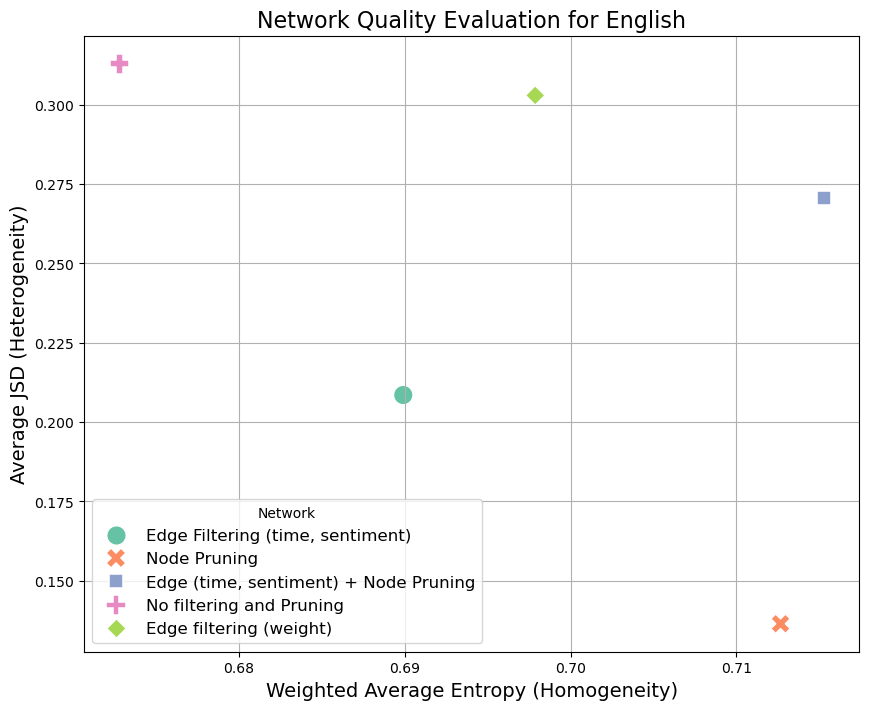

In [56]:
# Evaluate networks
results = {}
for network_name, file_path in {
    'Edge Filtering (time, sentiment)': "en_fused_filtered.csv",
    'Node Pruning': "en_fused_baseline.csv",
    'Edge (time, sentiment) + Node Pruning': "en_fused_all.csv", 
    'No filtering and Pruning': "en_fused_nothing.csv",
    'Edge filtering (weight)': "en_low_weight_filtered.csv"
}.items():
    clusters = load_clusters(file_path, en_data)
    filtered_clusters = filter_sparse_clusters(clusters, min_docs=10, min_max_EC=0.2)
    entropy, jsd = evaluate_network(filtered_clusters, en_data)
    results[network_name] = (entropy, jsd)


# Prepare data for Seaborn
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Entropy', 'JSD']).reset_index()
results_df.rename(columns={'index': 'Network'}, inplace=True)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=results_df, x='Entropy', y='JSD', hue='Network', style='Network', s=200, palette='Set2')

# # Annotate each point
# for _, row in results_df.iterrows():
#     plt.text(row['Entropy'] + 0.01, row['JSD'] + 0.01, row['Network'], fontsize=12)

# Add labels and title
plt.xlabel('Weighted Average Entropy (Homogeneity)', fontsize=14)
plt.ylabel('Average JSD (Heterogeneity)', fontsize=14)
plt.title('Network Quality Evaluation for English', fontsize=16)
plt.grid(True)
plt.legend(title='Network', fontsize=12)
plt.savefig("network_evaluation_en.png", dpi=300, bbox_inches='tight')
plt.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

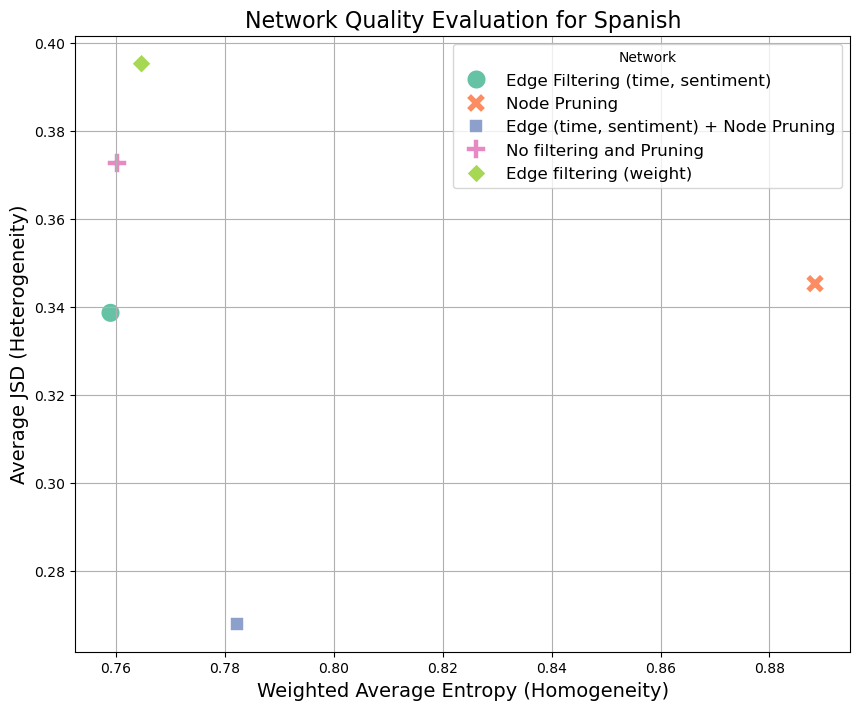

In [16]:
# Evaluate networks
results = {}
for network_name, file_path in {
    'Edge Filtering (time, sentiment)': "es_filtered_graph.csv",
    'Node Pruning': "es_fused_baseline.csv",
    'Edge (time, sentiment) + Node Pruning': "es_fused_all.csv", 
    'No filtering and Pruning': "es_fused_nothing.csv",
    'Edge filtering (weight)': "es_low_weight_filtered.csv"
}.items():
    clusters = load_clusters(file_path, es_data)
    filtered_clusters = filter_sparse_clusters(clusters, min_docs=10, min_max_EC=0.2)
    entropy, jsd = evaluate_network(filtered_clusters, es_data)
    results[network_name] = (entropy, jsd)


# Prepare data for Seaborn
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Entropy', 'JSD']).reset_index()
results_df.rename(columns={'index': 'Network'}, inplace=True)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=results_df, x='Entropy', y='JSD', hue='Network', style='Network', s=200, palette='Set2')

# # Annotate each point
# for _, row in results_df.iterrows():
#     plt.text(row['Entropy'] + 0.01, row['JSD'] + 0.01, row['Network'], fontsize=12)

# Add labels and title
plt.xlabel('Weighted Average Entropy (Homogeneity)', fontsize=14)
plt.ylabel('Average JSD (Heterogeneity)', fontsize=14)
plt.title('Network Quality Evaluation for Spanish', fontsize=16)
plt.grid(True)
plt.legend(title='Network', fontsize=12)
plt.savefig("network_evaluation_es.png", dpi=300, bbox_inches='tight')
plt.show()
